In [1]:
import glob
import numpy as np
import time

# 获取所有的文件
RA_files = glob.glob('/xiongjun/test/MIL/data/0.9_RA/*/*.csv')
print(len(RA_files))

# 获取所有的标签
labels = set([file.split('/')[-2] for file in RA_files])
print(labels)

# 初始化训练集、验证集和测试集
train_files = []
val_files = []
test_files = []

# 对每个标签，随机分配文件到训练集、验证集和测试集
for label in labels:
    label_files = [file for file in RA_files if file.split('/')[-2] == label]
    np.random.shuffle(label_files)
    n = len(label_files)
    train_files += label_files[:int(n * 0.7)]
    val_files += label_files[int(n * 0.7):int(n * 0.9)]
    test_files += label_files[int(n * 0.9):]

print(f"Train: {len(train_files)} Val: {len(val_files)} Test: {len(test_files)}")

1067
{'0', '6', '2', '5', '3', '1', '4'}
Train: 745 Val: 213 Test: 109


In [2]:
import pandas as pd
import concurrent.futures

def read_file(file):
    return pd.read_csv(file)

def read_files2(fileslist):
    # 使用进程池来并行读取文件
    with concurrent.futures.ProcessPoolExecutor() as executor:
        dfs = list(executor.map(read_file, fileslist))

    # 合并所有的DataFrame
    if not dfs:
        return pd.DataFrame()
    result = pd.concat(dfs, ignore_index=True)
    return result

def read_files1(fileslist):
    # 初始化一个空的DataFrame列表
    dfs = []
    # 读取每个文件并添加到列表中
    for file in fileslist:
        df = pd.read_csv(file)
        dfs.append(df)

    # 合并所有的DataFrame
    if not dfs:
        return pd.DataFrame()
    result = pd.concat(dfs, ignore_index=True)
    return result

In [3]:
start_time = time.time()
result1 = read_files1(test_files)
end_time = time.time()
runtime1 = end_time - start_time

start_time = time.time()
result2 = read_files2(test_files)
end_time = time.time()
runtime2 = end_time- start_time


In [4]:
is_equal = result1.equals(result2)

In [5]:
import ast
import multiprocessing

In [6]:
def process_data(data):
    return data.apply(ast.literal_eval)

def parallelize_dataframe(df, func, n_cores):
    df_split = np.array_split(df, n_cores)
    pool = multiprocessing.Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
start_time = time.time()
result1['data'] = result1['data'].map(ast.literal_eval)
end_time = time.time()
runtime3 = end_time - start_time

start_time = time.time()
result2['data'] = result2['data'].apply(eval)
end_time = time.time()
runtim4 = end_time - start_time

In [8]:
result3 = read_files2(test_files)
start_time = time.time()
result3['data'] = parallelize_dataframe(result3['data'], \
            process_data,multiprocessing.cpu_count())
end_time = time.time()
runtim5 = end_time - start_time

In [ ]:
import concurrent.futures
result4 = read_files2(test_files)
def process_data(data):
    return eval(data)

start_time = time.time()
with concurrent.futures.ThreadPoolExecutor() as executor:
    result4['data'] = list(executor.map(process_data, result4['data']))
end_time = time.time()
runtim6 = end_time - start_time

In [5]:
import pandas as pd


column_names = ["aaSeqCDR3", "cloneFraction", "sth1", "sample"]
# 读取CSV文件
raw_data = pd.read_csv("/xiongjun/test/MIL/data/healthy/emerson_healthy_train.csv", names=column_names)
# 假设你的DataFrame对象的名称为df
total = raw_data[raw_data['sample'] == 'HIP19717']['cloneFraction'].sum()
total

0.17363059099999997

In [6]:
raw_data.head(10)

,aaSeqCDR3,cloneFraction,sth1,sample
0,CATTGTSGGPSQSTQYF,0.013719,1,HIP00110
1,CASSLRVGGYGYTF,0.013587,2,HIP00110
2,CASRRLGGLNTEAFF,0.007683,3,HIP00110
3,CASSLRGSGNTIYF,0.004399,4,HIP00110
4,CASRQDGSTEAFF,0.003996,5,HIP00110
5,CASSRARVFGNYGYTF,0.003134,6,HIP00110
6,CASSQADNQPQHF,0.002864,7,HIP00110
7,CASSKTGTSGSDTQYF,0.002660,8,HIP00110
8,CASSESGQPTGELFF,0.002221,9,HIP00110
9,CASSVALMPGNSPLHF,0.002094,10,HIP00110


In [2]:

import numpy as np
import torch


def group_max(groups, data, nmax):
    out = np.empty(nmax)
    out[:] = np.nan
    order = np.lexsort((data, groups))
    groups = groups[order]
    data = data[order]
    index = np.empty(len(groups), 'bool')
    index[-1] = True
    index[:-1] = groups[1:] != groups[:-1]
    out[groups[index]] = data[index]
    return out

def group_argtopk(groups, data,k=1):
    order = np.lexsort((data, groups))
    groups = groups[order]
    data = data[order]
    index = np.empty(len(groups), 'bool')
    index[-k:] = True
    index[:-k] = groups[k:] != groups[:-k]
    return list(order[index])


probs = torch.FloatTensor([0.8,0.7,0.2,0.4,0.5,0.1,0.98,0.4])
slideIDX = [0,0,1,1,2,2,3,3]
topk = group_max(np.array(slideIDX), probs, 4)
topk

array([0.80000001, 0.40000001, 0.5       , 0.98000002])

In [ ]:
import pandas as pd

data = pd.read_csv('/xiongjun/test/MIL/data/0.9_RA/0/H2001A008_RA_stats.csv')

# 根据"数量"列进行降序排序
data_sorted = data.sort_values(by='RA_4mer', ascending=False)

# 获取前10行
top_10 = data_sorted.head(10)

# 打印"名称"和"数量"列
for index, row in top_10.iterrows():
    print(f"4_mer: {row['4-mer']}, 4_mer_RA: {row['RA_4mer']}")
import pandas as pd
import numpy as np

# 创建示例数据
data = {
    '4-mer-1': ['ACGT', 'TGCA', 'CGAT', np.nan],
    '4-mer-2': ['ATCG', 'GGTC', 'CTAG', 'TCGA'],
    '4-mer-3': ['CGTA', 'ACGT', np.nan, 'TGCA'],
    '4-mer-4': ['GCTA', 'TCGA', 'ATCG', 'CGAT'],
    'cloneFraction': [0.8, 0.6, 0.9, 0.7]
}

# 创建DataFrame
data_filtered = pd.DataFrame(data)

# 显示DataFrame
print(data_filtered)


In [2]:
# 初始化一个字典来存储每种4-mer序列的相对丰度值
# 找到所有的 '4-mer' 列
four_mer_columns = data_filtered.filter(regex='4-mer')

# 将 '4-mer' 列和 'ratio' 列合并
df_melted = pd.melt(data_filtered, id_vars='cloneFraction', value_vars=four_mer_columns.columns, var_name='4-mer_col', value_name='4-mer')
# 删除4-mer列中的NaN值
df_melted = df_melted.dropna(subset=['4-mer'])
# 计算每种4-mer的最大ratio值
TCR_RA_stats = df_melted.groupby('4-mer')['cloneFraction'].max().reset_index()
TCR_RA_stats.columns = ['4-mer', 'RA']
TCR_RA_stats.head(10)

,4-mer,RA
0,ACGT,0.8
1,ATCG,0.9
2,CGAT,0.9
3,CGTA,0.8
4,CTAG,0.9
5,GCTA,0.8
6,GGTC,0.6
7,TCGA,0.7
8,TGCA,0.7


In [3]:
relative_abundance = {}

# 遍历每一行数据
for index, row in data_filtered.iterrows():
    # 遍历除了最后一列（cloneFraction）以外的所有列
    for col in four_mer_columns.columns:
        # 如果该列的值不是NaN，则将其相对丰度值累加到相应的键中
        if not pd.isna(row[col]):
            # 使用setdefault方法来初始化字典中键的默认值为0，然后累加cloneFraction值
            relative_abundance.setdefault(row[col], 0)
            relative_abundance[row[col]] += row['cloneFraction']



_4mer_RA_stats = pd.DataFrame(list(relative_abundance.items()), columns=['4-mer', 'RA'])
sumra = _4mer_RA_stats['RA'].sum()
_4mer_RA_stats['RA'] = _4mer_RA_stats['RA'] / sumra
_4mer_RA_stats.head(10)

,4-mer,RA
0,ACGT,0.134615
1,ATCG,0.163462
2,CGTA,0.076923
3,GCTA,0.076923
4,TGCA,0.125000
5,GGTC,0.057692
6,TCGA,0.125000
7,CGAT,0.153846
8,CTAG,0.086538


In [4]:
RA_stats = _4mer_RA_stats.merge(TCR_RA_stats, on='4-mer', suffixes=('_4mer', '_TCR'))
RA_stats.head(10)

,4-mer,RA_4mer,RA_TCR
0,ACGT,0.134615,0.8
1,ATCG,0.163462,0.9
2,CGTA,0.076923,0.8
3,GCTA,0.076923,0.8
4,TGCA,0.125000,0.7
5,GGTC,0.057692,0.6
6,TCGA,0.125000,0.7
7,CGAT,0.153846,0.9
8,CTAG,0.086538,0.9


In [ ]:
import glob
RA_path = "/xiongjun/test/MIL/data/1_zz_RA/*/*.csv"
RA_files = glob.glob(RA_path)
labels = set([file.split('/')[-2] for file in RA_files])
labels

{'0', '1', '2', '3', '4', '5', '6'}

In [3]:
flattened_df = flatten_data(df, 4)
C_values = flattened_df.groupby('4-mer')['cloneFraction'].sum().reset_index()\
    .set_index('4-mer')['cloneFraction'].squeeze()

In [5]:
import glob
RA_path = "/xiongjun/test/MIL/data/1_zz_RA/*/*.csv"
RA_files = glob.glob(RA_path)
labels = set([file.split('/')[-2] for file in RA_files])
labels

{'0', '1', '2', '3', '4', '5', '6'}

Accuracy: 0.8


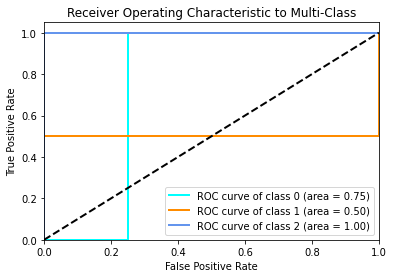

In [2]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np
import torch

# 假设你有以下的真实标签和预测概率
labels = torch.tensor([0, 1, 2, 2, 1])  # 真实标签
output = torch.tensor([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.2, 0.2, 0.6], [0.1, 0.2, 0.7], [0.9, 0.05, 0.05]])  # 预测概率

_, predicted = torch.max(output, 1)
correct = torch.eq(predicted, labels).sum().item()
total = labels.size(0)
accuracy = correct / total
print("Accuracy:", accuracy)

# 绘制ROC曲线
y_test = label_binarize(labels.numpy(), classes=[0, 1, 2])
y_score = output.detach().numpy()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i, color in zip(range(3), ['aqua', 'darkorange', 'cornflowerblue']):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()


In [3]:
dfs = []
if  dfs:
    print("a")

In [3]:
import torch

# 假设你有以下的张量列表
tensors = [torch.randn(n, ) for n in [4, 3, 5, 2]]

# 使用torch.cat将它们堆叠起来
result = torch.cat(tensors, dim=0)

print(result.shape)  # 输出：torch.Size([14, 7])

torch.Size([14])


In [5]:
import numpy as np
import pandas as pd

# 定义数据
data = "A,-0.591,-1.302,-0.733,1.570,-0.146;C,-1.343,0.465,-0.862,-1.020,-0.255;D,1.050,0.302,-3.656,-0.259,-3.242;E,1.357,-1.453,1.477,0.113,-0.837;F,-1.006,-0.590,1.891,-0.397,0.412;G,-0.384,1.652,1.330,1.045,2.064;H,0.336,-0.417,-1.673,-1.474,-0.078;I,-1.239,-0.547,2.131,0.393,0.816;K,1.831,-0.561,0.533,-0.277,1.648;L,-1.019,-0.987,-1.505,1.266,-0.912;M,-0.663,-1.524,2.219,-1.005,1.212;N,0.945,0.828,1.299,-0.169,0.933;P,0.189,2.081,-1.628,0.421,-1.392;Q,0.931,-0.179,-3.005,-0.503,-1.853;R,1.538,-0.055,1.502,0.440,2.897;S,-0.228,1.399,-4.760,0.670,-2.647;T,-0.032,0.326,2.213,0.908,1.313;V,-1.337,-0.279,-0.544,1.242,-1.262;W,-0.595,0.009,0.672,-2.128,-0.184;Y,0.260,0.830,3.097,-0.838,1.512"

# 将数据分割成列表
data_list = [item.split(',') for item in data.split(';')]

# 创建DataFrame
atchley = pd.DataFrame(data_list, columns=["amino.acid", "f1", "f2", "f3", "f4", "f5"])

# 将f1-f5列转换为数值类型
atchley[["f1", "f2", "f3", "f4", "f5"]] = atchley[["f1", "f2", "f3", "f4", "f5"]].apply(pd.to_numeric)

# 将amino.acid列设置为索引
atchley.set_index("amino.acid", inplace=True)
# 创建映射表
features_dict = {row[0]: list(row[1:]) for row in atchley.itertuples()}

# 定义优化后的函数
def sequence_to_values_optimized(sequence):
    return [features_dict[amino_acid] for amino_acid in sequence]

# 测试函数
sequence = "ACDEFGHIKLMNPQRSTVWY"
result = sequence_to_values_optimized(sequence)
print(result)

[[-0.591, -1.302, -0.733, 1.57, -0.146], [-1.343, 0.465, -0.862, -1.02, -0.255], [1.05, 0.302, -3.656, -0.259, -3.242], [1.357, -1.453, 1.477, 0.113, -0.837], [-1.006, -0.59, 1.891, -0.397, 0.412], [-0.384, 1.652, 1.33, 1.045, 2.064], [0.336, -0.417, -1.673, -1.474, -0.078], [-1.239, -0.547, 2.131, 0.393, 0.816], [1.831, -0.561, 0.533, -0.277, 1.648], [-1.019, -0.987, -1.505, 1.266, -0.912], [-0.663, -1.524, 2.219, -1.005, 1.212], [0.945, 0.828, 1.299, -0.169, 0.933], [0.189, 2.081, -1.628, 0.421, -1.392], [0.931, -0.179, -3.005, -0.503, -1.853], [1.538, -0.055, 1.502, 0.44, 2.897], [-0.228, 1.399, -4.76, 0.67, -2.647], [-0.032, 0.326, 2.213, 0.908, 1.313], [-1.337, -0.279, -0.544, 1.242, -1.262], [-0.595, 0.009, 0.672, -2.128, -0.184], [0.26, 0.83, 3.097, -0.838, 1.512]]


In [2]:
import torch
import torch.nn.functional as F
# 假设outputs是你的模型的输出，labels是真实的标签
outputs = torch.randn(10, 4)  # 假设有10个样本，每个样本有4个类别
labels = torch.randint(4, (10,))  # 假设有10个样本，每个样本的标签是0到3之间的一个整数

# 使用softmax函数
outputs = F.softmax(outputs, dim=1)

# 使用argmax函数获取每个样本的预测标签
_, predicted = torch.max(outputs, 1)

# 使用eq函数比较预测标签和真实标签
correct = (predicted == labels).sum().item()

# 计算正确率
accuracy = correct / labels.size(0)
print(accuracy)

,A,B,key
0,A0,B0,K0
1,A1,B1,K1
2,A2,B2,K2
3,A3,B3,K3


In [3]:
# 创建第二个DataFrame
df2 = pd.DataFrame({
    'C': ['C0', 'C1', 'C2'],
    'D': ['D0', 'D1', 'D2'],
    'key': ['K0', 'K1', 'K2']
})
df2.head()

,C,D,key
0,C0,D0,K0
1,C1,D1,K1
2,C2,D2,K2


In [4]:
# 执行左连接
result = pd.merge(df1, df2, on='key', how='left')
result.head()

,A,B,key,C,D
0,A0,B0,K0,C0,D0
1,A1,B1,K1,C1,D1
2,A2,B2,K2,C2,D2
3,A3,B3,K3,NaN,NaN


In [4]:
def tuples_to_dataframe(tuples_list):
    rows = []
    for tup in tuples_list:
        # 获取元组中除了最后一个元素之外的所有元素
        row = list(tup[:-1])
        rows.append(row)
    
    # 创建DataFrame
    df = pd.DataFrame(rows, columns=['data', 'RA_4mer', 'RA_TCR', '4-mer', 'label', 'sample'])
    
    return df

# 创建模拟数据
tuples_list = [
    (torch.randn(4, 5).tolist(), torch.randn(1,), torch.randn(1,), 'name1', 0, 'sample1', 1),
    (torch.randn(4, 5).tolist(), torch.randn(1,), torch.randn(1,), 'name2', 1, 'sample2', 2),
    (torch.randn(4, 5).tolist(), torch.randn(1,), torch.randn(1,), 'name3', 2, 'sample3', 3)
]

# 将元组列表转换为DataFrame
dataframe = tuples_to_dataframe(tuples_list)
dataframe.head()

,data,RA_4mer,RA_TCR,4-mer,label,sample
0,"[[-0.338273286819458, -0.7951063513755798, -0....",[tensor(0.1137)],[tensor(0.3226)],name1,0,sample1
1,"[[1.3016526699066162, 0.5786869525909424, 0.67...",[tensor(-0.6772)],[tensor(-0.4265)],name2,1,sample2
2,"[[-0.8226626515388489, -0.6997305750846863, -2...",[tensor(0.7432)],[tensor(-0.3827)],name3,2,sample3


In [2]:
def find_topk(res, topk):
    # 按照v1值对列表进行排序，为分组做准备
    res_sorted = sorted(res, key=lambda x: x[5])
    
    # 结果列表
    result = []
    print("start find topk")
    # 按v1值进行分组
    for v1, group in groupby(res_sorted, key=lambda x: x[5]):
        # 在每个分组内按照v2值进行排序（降序），提取前topk个元素
        topk_tuples = sorted(group, key=lambda x: float(x[6]), reverse=True)[:topk]
        # 将提取的元组添加到结果列表中，但是只包括key和v1
        result.extend([t for t in topk_tuples])
    return result

In [3]:
a = [(1, 2, 3, 4, 5, 'a', 1), (1, 2, 3, 4, 5, 'a', 2), (1, 2, 3, 4, 5, 'a', 3),\
     (1, 2, 3, 4, 5, 'b', 3), (1, 2, 3, 4, 5, 'b', 2), (1, 2, 3, 4, 5, 'b', 3)]
topk = 2
find_topk(a, topk)

start find topk


[(1, 2, 3, 4, 5, 'a', 3),
 (1, 2, 3, 4, 5, 'a', 2),
 (1, 2, 3, 4, 5, 'b', 3),
 (1, 2, 3, 4, 5, 'b', 3)]

In [ ]:
import torch

a = torch.tensor([[1], [2], [3]])
b = a.view(-1)
print(b)
print(a)

In [ ]:
for i in range(tensor.shape[1]):
    sub_tensor = tensor[:, i, :]
    print(sub_tensor)

In [ ]:
import torch

# 假设你的列表是data
data = [torch.tensor([1, 2, 3]), torch.tensor([4, 5, 6]), torch.tensor([7, 8, 9])]

# 使用torch.stack()函数将一维张量堆叠成二维张量
data_2d = torch.stack(data)

print(data_2d[1])

In [ ]:
# 假设你的DataFrame对象是df
for index, row in df.iterrows():
    print(row['sample'], row['value'])

In [ ]:
a = df['sample']
b = a.values
b

In [ ]:
# 使用groupby方法创建一个DataFrameGroupBy对象
grouped_df = df.groupby('sample')

# 使用get_group方法获取sample值为'A'的所有行
group_A = grouped_df.get_group('A')

group_A.head()


In [ ]:
class A:
    def method(self):
        print("This is method from class A")

class B(A):
    def method(self, use_super):
        if use_super:
            super().method()  # 调用父类的方法
        else:
            print("This is method from class B")  # 不调用父类的方法，执行其他操作

# 创建一个B类的实例
b = B()

In [ ]:
# 调用方法
b.method(True)  # 输出: This is method from class A
b.method(False)  # 输出: This is method from class B

In [ ]:
a = "[[1,2,3],[4,5,6]]"
b= eval(a)
b